In [21]:
#Question 2
import numpy as np
import matplotlib.pyplot as plt

def logistic_loss(w, x, y):
    """Scalar logistic loss for 1D features."""
    vals = np.log(1 + np.exp(-y * (w * x)))
    return np.mean(vals)

#given touples 
datasets = {
    "Case A": {
        "x": np.array([-1.0, 0.0, 1.0]),
        "y": np.array([-1.0, 1.0, -1.0])
    },
    "Case B": {
        "x": np.array([-2.0, -1.0, 0.0, 1.0]),
        "y": np.array([-1.0, -1.0, 1.0, 1.0])
    }
}



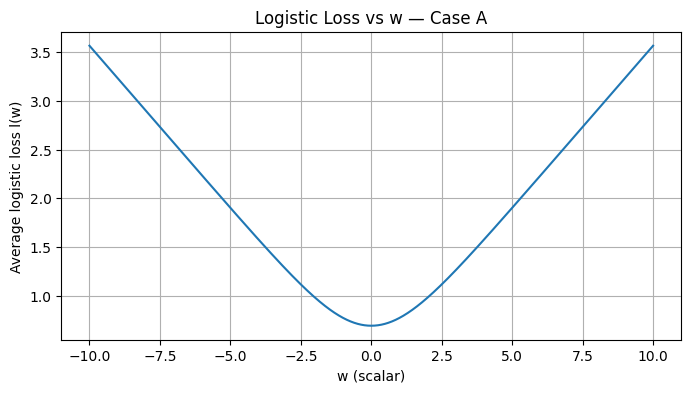

Case A:
  Approx min at w ≈ 0.000
  Min loss ≈ 0.693147
  Loss(w=-10)=3.564413, Loss(w=10)=3.564413
---------------------------------------------------


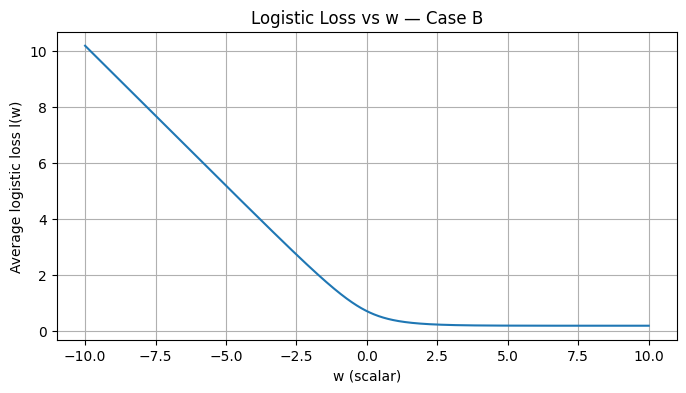

Case B:
  Approx min at w ≈ 10.000
  Min loss ≈ 0.173309
  Loss(w=-10)=10.173309, Loss(w=10)=0.173309
---------------------------------------------------


In [22]:
# w values
w_vals = np.linspace(-10, 10, 2001)

#plots
for name, data in datasets.items():
    losses = np.array([logistic_loss(w, data["x"], data["y"]) for w in w_vals])

    
    plt.figure(figsize=(8, 4))
    plt.plot(w_vals, losses)
    plt.title(f"Logistic Loss vs w — {name}")
    plt.xlabel("w (scalar)")
    plt.ylabel("Average logistic loss l(w)")
    plt.grid(True)
    plt.show()

    
    idx = np.argmin(losses)
    print(f"{name}:")
    print(f"  Approx min at w ≈ {w_vals[idx]:.3f}")
    print(f"  Min loss ≈ {losses[idx]:.6f}")
    print(f"  Loss(w=-10)={losses[0]:.6f}, Loss(w=10)={losses[-1]:.6f}")
    print("---------------------------------------------------")


In [23]:
#Part 2
from sklearn.datasets import make_classification


In [24]:
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eigvalsh, norm
from scipy.stats import linregress
import pandas as pd
import time

np.random.seed(42)


n_samples = 500       #number of samples
n_features = 20       #feature
X, y = make_classification(n_samples=n_samples, n_features=n_features,
                           n_informative=10, n_redundant=2, n_classes=2,
                           class_sep=1.0, flip_y=0.01, random_state=1)
y = 2*y - 1           #labels to {-1, +1}



In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

add_bias = True
if add_bias:
    X = np.hstack([X, np.ones((X.shape[0], 1))])
    n_features = X.shape[1]

print("Dataset:", n_samples, "samples x", n_features, "features (bias included)")

def sigmoid(t):
    return 1.0 / (1.0 + np.exp(-t))

def loss(w):
    z = y * (X.dot(w))
    return np.mean(np.log1p(np.exp(-z)))

def grad(w):
    z = y * (X.dot(w))
    s = 1.0 / (1.0 + np.exp(z))   # sigmoid(-z)
    return - (1.0 / X.shape[0]) * (X.T.dot(y * s))

XtX = (X.T.dot(X)) / X.shape[0]
max_eig_XtX = eigvalsh(XtX).max()
L_bound = 0.25 * max_eig_XtX
print("Lipschitz upper bound estimate L_bound =", L_bound)

def numeric_L_estimate(samples=10):
    max_eigs = []
    for _ in range(samples):
        w_rand = np.random.randn(X.shape[1])
        z = sigmoid(y * (X.dot(w_rand)))
        D = z * (1 - z)
        H = (1.0 / X.shape[0]) * (X.T * D).dot(X)
        max_eigs.append(eigvalsh(H).max())
    return max(max_eigs)



Dataset: 500 samples x 21 features (bias included)
Lipschitz upper bound estimate L_bound = 0.6847895204974688


In [26]:
numeric_L = numeric_L_estimate(8)
L = max(L_bound, numeric_L)
print("Numeric L (sampled) =", numeric_L, " -> chosen L =", L)

# To get l*, running GD with step 1/(2L) for many iterations (larger -> better approx)
# For exact project results you should run this for 50k–100k iterations; here we use smaller for speed.
def gradient_descent_simple(w0, step, iters):
    w = w0.copy()
    for _ in range(iters):
        w -= step * grad(w)
    return w

w0 = np.zeros(n_features)
iters_lstar = 20000     #can be increased to 100k 
step_for_lstar = 1.0 / (2.0 * L + 1e-12)
print("Computing approximate l* with {} iterations (step=1/(2L)) ...".format(iters_lstar))
t0 = time.time()
w_lstar = gradient_descent_simple(w0, step_for_lstar, iters_lstar)
t1 = time.time()
l_star = loss(w_lstar)
print("approx l* =", l_star, "computed in {:.1f}s".format(t1-t0))

#implementatin
max_iters = 5000      
print("Running experiments with max_iters =", max_iters)

def run_fixed_gd(alpha, iters=max_iters):
    w = np.zeros(n_features)
    losses = np.zeros(iters)
    for k in range(iters):
        w -= alpha * grad(w)
        losses[k] = loss(w)
    return w, losses

def run_diminishing(alpha0, iters=max_iters):
    w = np.zeros(n_features)
    losses = np.zeros(iters)
    for k in range(iters):
        alpha_k = alpha0 / np.sqrt(k + 1.0)
        w -= alpha_k * grad(w)
        losses[k] = loss(w)
    return w, losses

def run_backtracking(iters=max_iters, alpha0=1.0, c=1e-4, tau=0.5):
    w = np.zeros(n_features)
    losses = np.zeros(iters)
    for k in range(iters):
        g = grad(w)
        alpha = alpha0
        fw = loss(w)
        # Armijo condition
        while True:
            w_new = w - alpha * g
            if loss(w_new) <= fw - c * alpha * (g.dot(g)):
                break
            alpha *= tau
            if alpha < 1e-15:
                break
        w = w_new
        losses[k] = loss(w)
    return w, losses

def run_ngd(beta_schedule="R_over_k_plus_1", R=5.0, iters=max_iters):
    w = np.zeros(n_features)
    losses = np.zeros(iters)
    for k in range(iters):
        g = grad(w)
        denom = norm(g)
        if denom < 1e-12:
            alpha = 0.0
        else:
            if beta_schedule == "R_over_k_plus_1":
                beta = R / (k + 1.0)
            else:
                beta = R / np.sqrt(k + 1.0)
            alpha = beta / (denom + 1e-15)
        w = w - alpha * g
        losses[k] = loss(w)
    return w, losses

def run_dual_averaging(alpha0=1.0, iters=max_iters):
    w0_da = np.zeros(n_features)
    w = w0_da.copy()
    g_sum = np.zeros(n_features)
    losses = np.zeros(iters)
    for k in range(1, iters + 1):
        g = grad(w)
        g_sum += g
        alpha_k = alpha0 / np.sqrt(k)
        # simple dual averaging update: (prox with quadratic center w0_da)
        w = w0_da - alpha_k * g_sum
        losses[k - 1] = loss(w)
    return w, losses

def run_polyak(l_star_est, iters=max_iters):
    w = np.zeros(n_features)
    losses = np.zeros(iters)
    for k in range(iters):
        g = grad(w)
        denom = g.dot(g)
        if denom < 1e-12:
            alpha = 0.0
        else:
            numer = loss(w) - l_star_est
            alpha = max(0.0, numer / denom)    # if numer<=0 -> alpha=0
        w = w - alpha * g
        losses[k] = loss(w)
    return w, losses



Numeric L (sampled) = 0.33491977223488795  -> chosen L = 0.6847895204974688
Computing approximate l* with 20000 iterations (step=1/(2L)) ...


approx l* = 0.2865052246525324 computed in 0.5s
Running experiments with max_iters = 5000


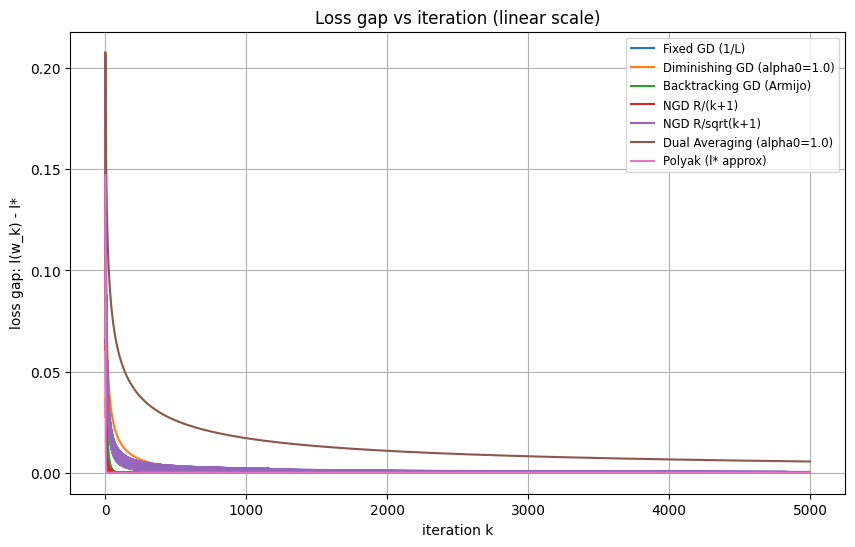

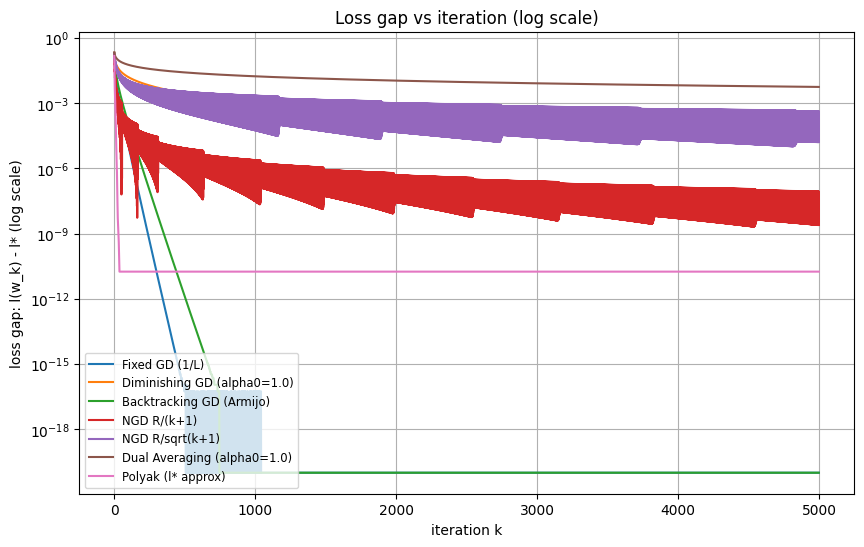

In [27]:
#hyperparameter
alpha_fixed = 1.0 / L                    #fixed GD step
alpha0_diminish = 1.0                    #diminishing GD base Tune: smaller if diverging; larger if too slow
alpha0_da = 1.0                          #dual averaging base
R_guess = 5.0                            # estimate of ||x0 - x*||; tune by hand


# ------ Running the six methods
methods = {}
methods["Fixed GD (1/L)"] = run_fixed_gd(alpha_fixed, max_iters)
methods["Diminishing GD (alpha0=1.0)"] = run_diminishing(alpha0_diminish, max_iters)
methods["Backtracking GD (Armijo)"] = run_backtracking(max_iters, alpha0=1.0, c=1e-4, tau=0.5)
methods["NGD R/(k+1)"] = run_ngd("R_over_k_plus_1", R_guess, max_iters)
methods["NGD R/sqrt(k+1)"] = run_ngd("R_over_sqrt_k_plus_1", R_guess, max_iters)
methods["Dual Averaging (alpha0=1.0)"] = run_dual_averaging(alpha0_da, max_iters)
methods["Polyak (l* approx)"] = run_polyak(l_star, max_iters)

# loss n plot
plt.figure(figsize=(10, 6))
for name, (w, losses) in methods.items():
    gap = losses - l_star
    plt.plot(gap, label=name)
plt.xlabel("iteration k")
plt.ylabel("loss gap: l(w_k) - l*")
plt.title("Loss gap vs iteration (linear scale)")
plt.legend(fontsize='small')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for name, (w, losses) in methods.items():
    gap = np.maximum(losses - l_star, 1e-20)
    plt.plot(gap, label=name)
plt.yscale("log")
plt.xlabel("iteration k")
plt.ylabel("loss gap: l(w_k) - l* (log scale)")
plt.title("Loss gap vs iteration (log scale)")
plt.legend(fontsize='small')
plt.grid(True)
plt.show()





In [28]:
#empirical
def estimate_loglog_rate(gap, k_start=50):
    
    k = np.arange(1, len(gap) + 1)
    kk = k[k_start-1:]
    yy = np.maximum(gap[k_start-1:], 1e-20)
    slope, intercept, r_value, p_value, std_err = linregress(np.log(kk), np.log(yy))
    return slope, intercept, r_value**2

rows = []
for name, (w, losses) in methods.items():
    gap = losses - l_star
    slope, intercept, r2 = estimate_loglog_rate(gap, k_start=50)
    rows.append({"method": name, "slope_loglog": slope, "intercept": intercept, "r2": r2})

rates_df = pd.DataFrame(rows).sort_values("slope_loglog")
print("\nEmpirical log-log rates (slope ~ exponent b in gap ~ k^b):")
print(rates_df.to_string(index=False))



Empirical log-log rates (slope ~ exponent b in gap ~ k^b):
                     method  slope_loglog  intercept           r2
   Backtracking GD (Armijo) -8.406252e+00  20.826323 7.120313e-01
             Fixed GD (1/L) -6.508474e+00   5.548835 6.388507e-01
                NGD R/(k+1) -1.990860e+00  -1.044365 5.000191e-01
Diminishing GD (alpha0=1.0) -1.883144e+00   5.716531 9.611970e-01
            NGD R/sqrt(k+1) -1.151786e+00   0.239020 2.770196e-01
Dual Averaging (alpha0=1.0) -6.309377e-01   0.237538 9.933567e-01
         Polyak (l* approx)  1.247223e-30 -24.755736 9.673470e-32


In [29]:
#PART 3

import time
#assume X, y are defined and standardized and bias added (same as Part II)
#logistic helpers
def sigmoid(t): return 1.0/(1.0+np.exp(-t))
def loss_unreg(w):
    z = y * (X.dot(w))
    return np.mean(np.log1p(np.exp(-z)))
def grad_unreg(w):
    z = y * (X.dot(w))
    s = 1.0/(1.0 + np.exp(z))  # = sigmoid(-z)
    return - (1.0 / X.shape[0]) * (X.T.dot(y * s))

#(same as Part I)
XtX = (X.T.dot(X)) / X.shape[0]
maxeig = eigvalsh(XtX).max()
L_data = 0.25 * maxeig   # analytic bound for logistic part

lambdas = [10.0, 1.0, 0.1, 0.01, 0.0001]
max_iters = 5000      # iterations to run each method per lambda
iters_lstar = 20000   

#projection onto ball
def proj_ball(w, mu):
    nrm = norm(w)
    if nrm <= mu: return w
    return (mu / nrm) * w

#store results in dict
all_results = {}




==== lambda = 10.0 ====
approx l*_lambda = 0.6805299313707874


C:\Users\soumy\AppData\Local\Temp\ipykernel_13192\2676794953.py:9: RuntimeWarning: overflow encountered in exp
  return np.mean(np.log1p(np.exp(-z)))
C:\Users\soumy\AppData\Local\Temp\ipykernel_13192\2676794953.py:12: RuntimeWarning: overflow encountered in exp
  s = 1.0/(1.0 + np.exp(z))  # = sigmoid(-z)


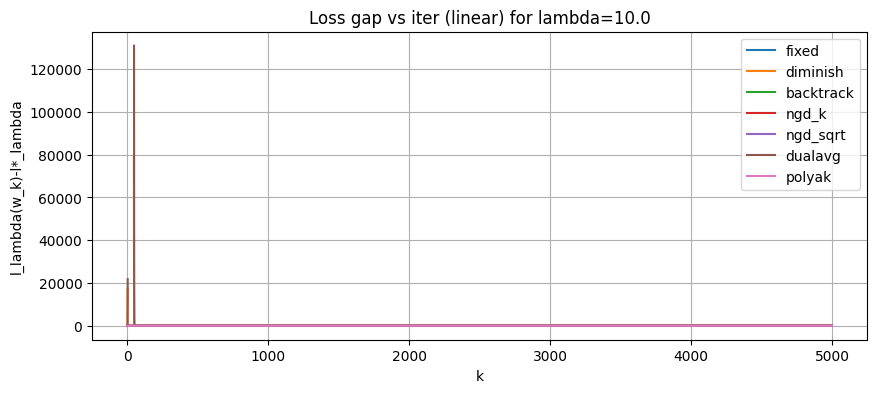

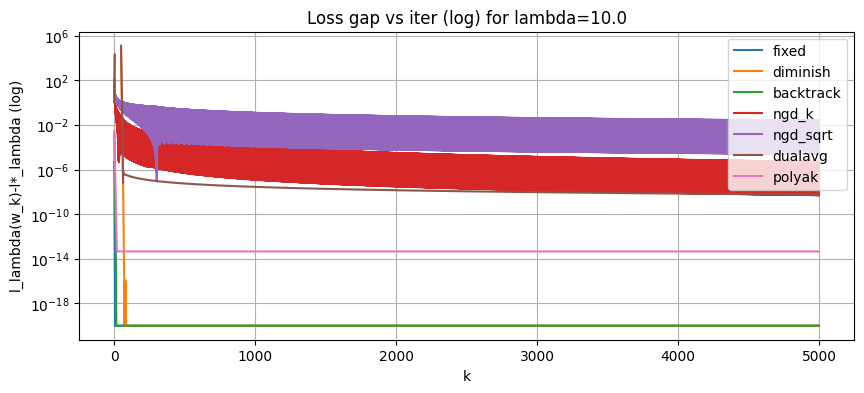

==== lambda = 1.0 ====
approx l*_lambda = 0.6048039612455275


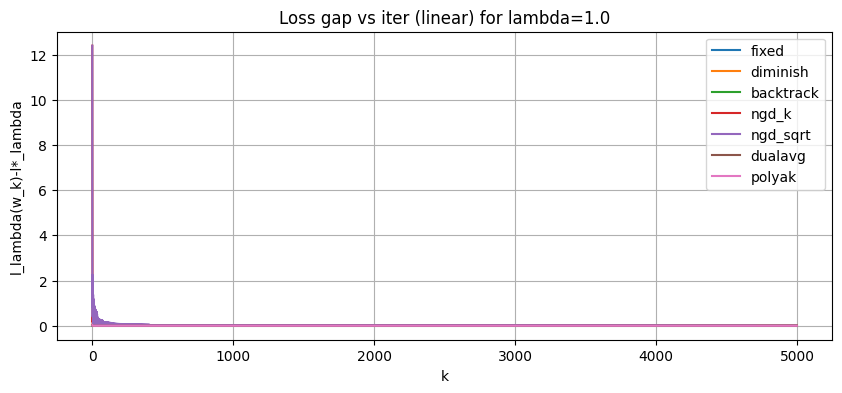

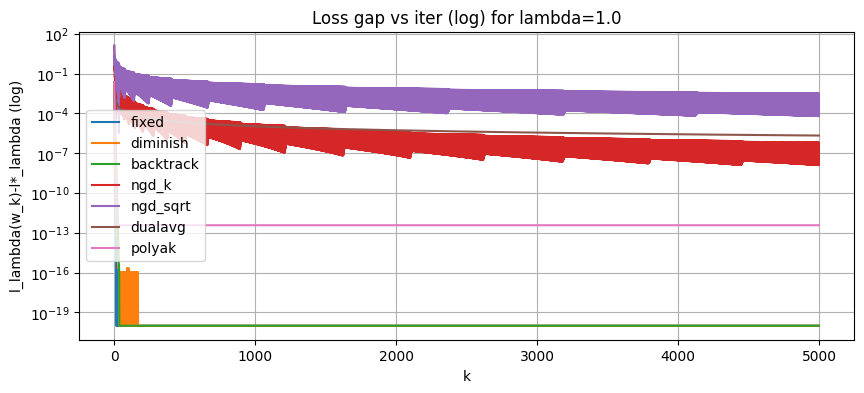

==== lambda = 0.1 ====
approx l*_lambda = 0.43425709662227757


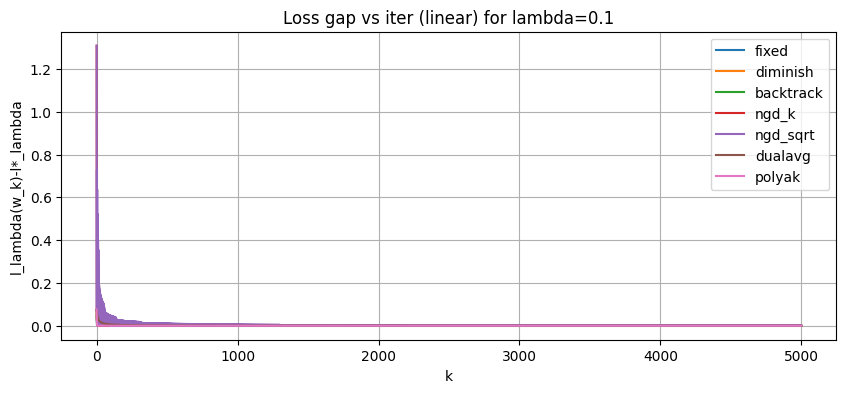

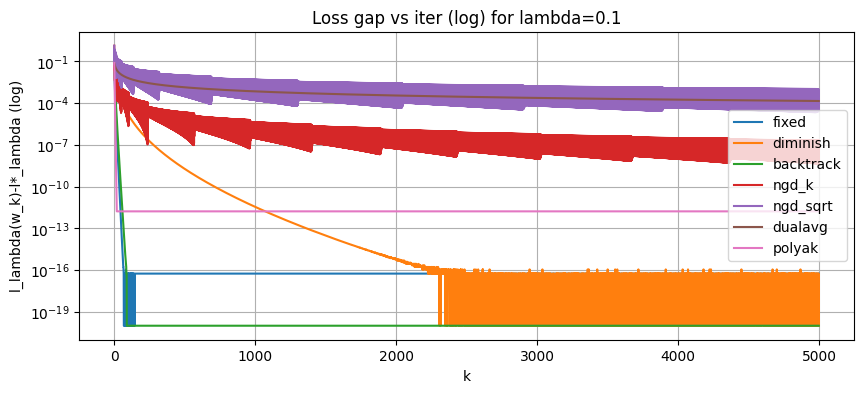

==== lambda = 0.01 ====
approx l*_lambda = 0.3203248945783601


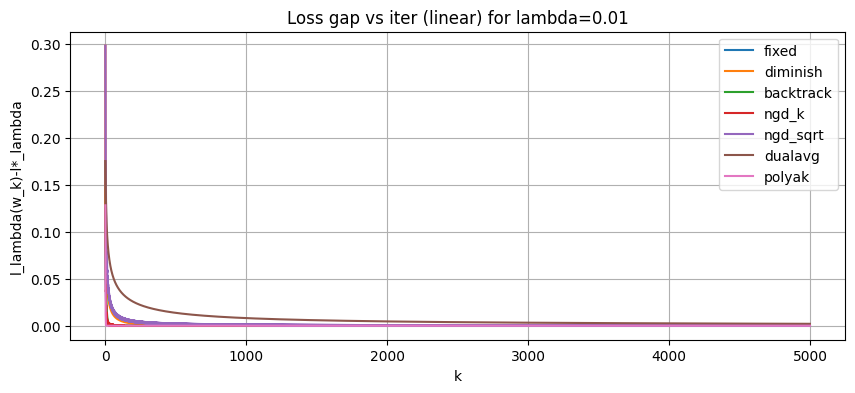

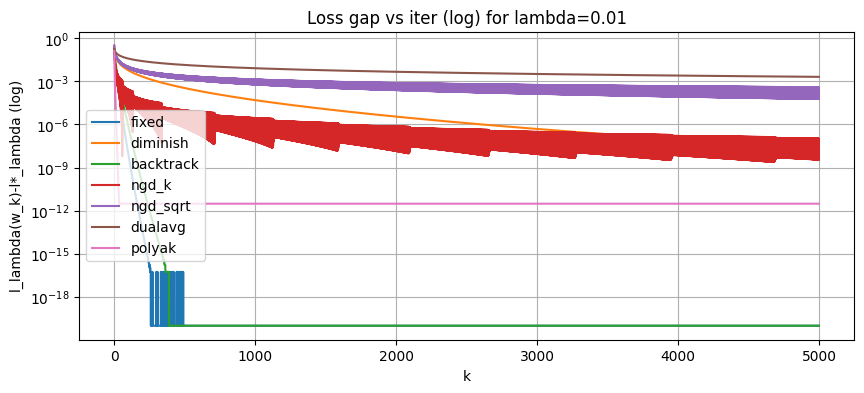

==== lambda = 0.0001 ====
approx l*_lambda = 0.2869513482077026


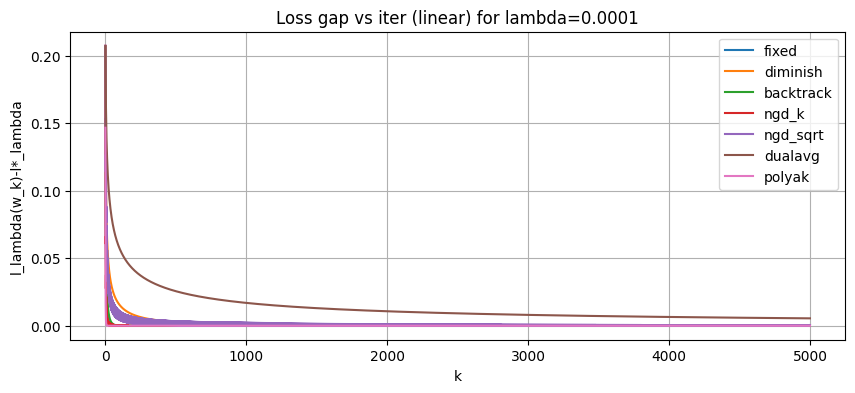

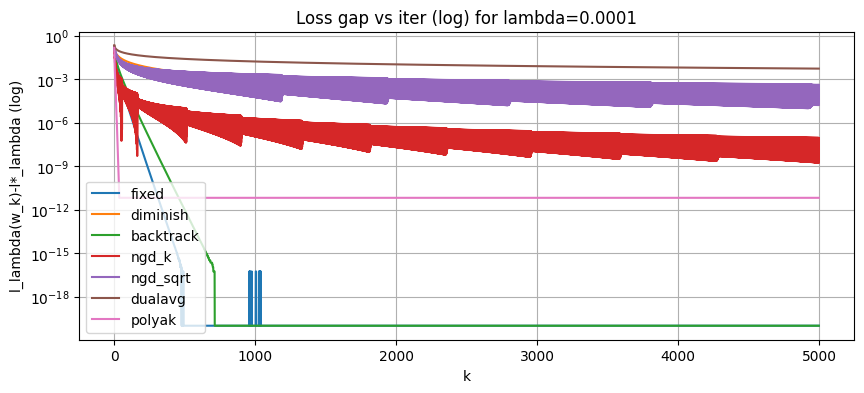

In [30]:
for lam in lambdas:
    print("==== lambda =", lam, "====")
    #regularized loss and gradient
    def loss_reg(w):
        return loss_unreg(w) + 0.5*lam*(w.dot(w))
    def grad_reg(w):
        return grad_unreg(w) + lam * w

    #L_reg estimate:
    L_reg = L_data + lam

    #pproximate l*_lambda using long-run GD with step 1/(2*L_reg)
    step_for_lstar = 1.0 / (2.0 * L_reg + 1e-12)
    w = np.zeros(X.shape[1])
    for _ in range(iters_lstar):
        w = w - step_for_lstar * grad_reg(w)
    lstar = loss_reg(w)
    print("approx l*_lambda =", lstar)

    #now running the methods (same implementations as in Part II but using loss_reg, grad_reg)
    #(i) Fixed GD (alpha = 1/L_reg)
    def run_fixed(alpha, iters=max_iters):
        w = np.zeros(X.shape[1]); losses = np.zeros(iters)
        for k in range(iters):
            w = w - alpha * grad_reg(w)
            losses[k] = loss_reg(w)
        return w, losses

    # (ii) diminishing: alpha0 / sqrt(k+1)
    def run_diminishing(alpha0, iters=max_iters):
        w = np.zeros(X.shape[1]); losses=np.zeros(iters)
        for k in range(iters):
            a = alpha0 / np.sqrt(k+1.0)
            w = w - a * grad_reg(w)
            losses[k] = loss_reg(w)
        return w, losses

    # (iii) backtracking Armijo (use loss_reg, grad_reg)
    def run_backtracking(iters=max_iters, alpha0=1.0, c=1e-4, tau=0.5):
        w = np.zeros(X.shape[1]); losses=np.zeros(iters)
        for k in range(iters):
            g = grad_reg(w)
            alpha = alpha0; fw = loss_reg(w)
            while True:
                wn = w - alpha * g
                if loss_reg(wn) <= fw - c * alpha * (g.dot(g)):
                    break
                alpha *= tau
                if alpha < 1e-15: break
            w = wn
            losses[k] = loss_reg(w)
        return w, losses

    # (iv) NGD
    def run_ngd(beta_schedule, R, iters=max_iters):
        w=np.zeros(X.shape[1]); losses=np.zeros(iters)
        for k in range(iters):
            g = grad_reg(w)
            gn = norm(g)
            if gn < 1e-12:
                alpha = 0.0
            else:
                if beta_schedule=='R_over_k_plus_1':
                    beta = R / (k+1.0)
                else:
                    beta = R / np.sqrt(k+1.0)
                alpha = beta / (gn + 1e-15)
            w = w - alpha * g
            losses[k] = loss_reg(w)
        return w, losses

    # (v) Dual Averaging (simple)
    def run_dual_averaging(alpha0, iters=max_iters):
        w0 = np.zeros(X.shape[1]); w = w0.copy(); gsum = np.zeros_like(w); losses=np.zeros(iters)
        for k in range(1,iters+1):
            g = grad_reg(w)
            gsum += g
            a = alpha0 / np.sqrt(k)
            w = w0 - a * gsum
            losses[k-1] = loss_reg(w)
        return w, losses

    # (vi) Polyak
    def run_polyak(lstar_est, iters=max_iters):
        w = np.zeros(X.shape[1]); losses=np.zeros(iters)
        for k in range(iters):
            g = grad_reg(w)
            denom = g.dot(g)
            if denom < 1e-12: a = 0.0
            else:
                numer = loss_reg(w) - lstar_est
                a = max(0.0, numer/denom)
            w = w - a * g
            losses[k] = loss_reg(w)
        return w, losses

    #run methods and collect results
    alpha_fixed = 1.0 / L_reg
    alpha0_diminish = 1.0
    R_guess = 5.0
    alpha0_da = 1.0

    res = {}
    res['fixed'] = run_fixed(alpha_fixed)
    res['diminish'] = run_diminishing(alpha0_diminish)
    res['backtrack'] = run_backtracking()
    res['ngd_k'] = run_ngd('R_over_k_plus_1', R_guess)
    res['ngd_sqrt'] = run_ngd('R_over_sqrt_k_plus_1', R_guess)
    res['dualavg'] = run_dual_averaging(alpha0_da)
    res['polyak'] = run_polyak(lstar)

    # compute loss gaps and empirical slopes (fit on log-log)
    stats = {}
    for name,(wsol, losses) in res.items():
        gap = np.maximum(losses - lstar, 1e-20)
        k_start = 50
        kvals = np.arange(1,len(gap)+1)
        slope, intercept, r_value, p_value, std_err = linregress(np.log(kvals[k_start-1:]), np.log(gap[k_start-1:]))
        stats[name] = {'slope': slope, 'r2': r_value**2}
    all_results[lam] = {'lstar': lstar, 'L_reg': L_reg, 'res': res, 'stats':stats}

    #plot loss gap for this lambda (linear + log)
    plt.figure(figsize=(10,4))
    for name,(wsol, losses) in res.items():
        plt.plot(np.maximum(losses - lstar, 0.0), label=name)
    plt.title(f"Loss gap vs iter (linear) for lambda={lam}")
    plt.xlabel('k'); plt.ylabel('l_lambda(w_k)-l*_lambda'); plt.legend(); plt.grid()
    plt.show()

    plt.figure(figsize=(10,4))
    for name,(wsol, losses) in res.items():
        plt.plot(np.maximum(losses - lstar, 1e-20), label=name)
    plt.yscale('log'); plt.title(f"Loss gap vs iter (log) for lambda={lam}")
    plt.xlabel('k'); plt.ylabel('l_lambda(w_k)-l*_lambda (log)'); plt.legend(); plt.grid()
    plt.show()

#part b

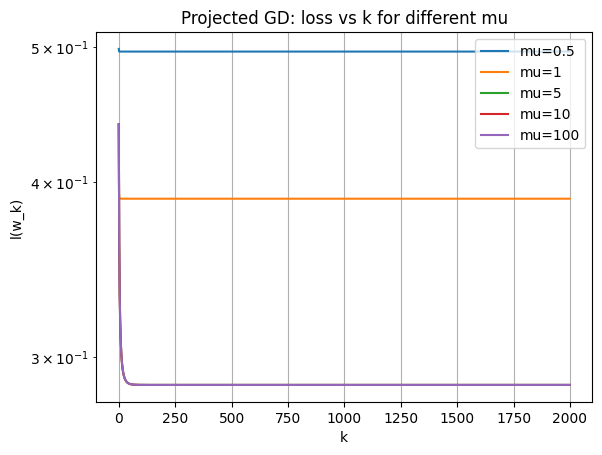

In [31]:
#c
mus = [0.5, 1, 5, 10, 100]
alpha = 1.0 / (L_data + 0.0)  # for unregularized L estimate; choose step <= 1/L
max_iters_proj = 2000

def run_projected_gd(mu, iters=max_iters_proj, alpha=alpha, use_backtracking=False):
    w = np.zeros(X.shape[1]); losses = np.zeros(iters)
    for k in range(iters):
        g = grad_unreg(w)
        if use_backtracking:
            # use same Armijo but with projection considered: try alpha then project
            alpha_t = 1.0
            fw = loss_unreg(w)
            while True:
                wn = proj_ball(w - alpha_t*g, mu)
                if loss_unreg(wn) <= fw - 1e-4 * alpha_t * (g.dot(g)): break
                alpha_t *= 0.5
                if alpha_t < 1e-12: break
            w = wn
        else:
            w = proj_ball(w - alpha * g, mu)
        losses[k] = loss_unreg(w)
    return w, losses

proj_results = {}
for mu in mus:
    wproj, losses_proj = run_projected_gd(mu)
    proj_results[mu] = (wproj, losses_proj)
    # plot or store
    plt.plot(losses_proj, label=f"mu={mu}")
plt.yscale('log'); plt.xlabel('k'); plt.ylabel('l(w_k)'); plt.title('Projected GD: loss vs k for different mu'); plt.legend(); plt.grid(); plt.show()


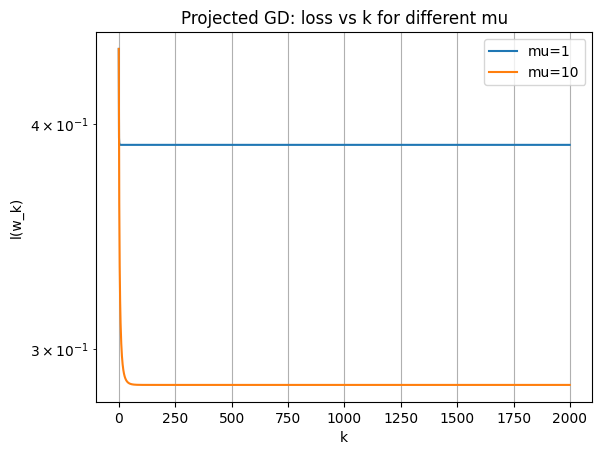

In [37]:
mus = [1, 10,]
for mu in mus:
    wproj, losses_proj = run_projected_gd(mu)
    proj_results[mu] = (wproj, losses_proj)
        # plot or store
    plt.plot(losses_proj, label=f"mu={mu}")
plt.yscale('log'); plt.xlabel('k'); plt.ylabel('l(w_k)'); plt.title('Projected GD: loss vs k for different mu'); plt.legend(); plt.grid(); plt.show()


In [38]:
# PART 4

In [39]:
X, y = make_classification(n_samples=2000, n_features=20, n_informative=10,
                           n_redundant=3, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# convertint hte labels to {-1, +1}
y = np.where(y == 0, -1, 1)

n, d = X.shape

def logistic_loss(w):
    z = y * (X @ w)
    return np.mean(np.log(1 + np.exp(-z)))

def full_gradient(w):
    z = y * (X @ w)
    grad = (-y[:, None] * X) * (1 / (1 + np.exp(z)))[:, None]
    return np.mean(grad, axis=0)

#stochastic gradient
def stochastic_grad(w, idx):
    xi = X[idx]
    yi = y[idx]
    z = yi * (xi @ w)
    return -yi * xi / (1 + np.exp(z))

#minibatch gradient
def minibatch_grad(w, batch_idx):
    grads = np.array([stochastic_grad(w, i) for i in batch_idx])
    return grads.mean(axis=0)


In [41]:
def SGD_decaying(t, max_iter=2000):
    w = np.zeros(d)
    losses = []
    for k in range(max_iter):
        idx = np.random.randint(n)
        g = stochastic_grad(w, idx)
        alpha = 1 / ((k + 1)**t)
        w = w - alpha * g
        losses.append(logistic_loss(w))
    return losses

#decreasing step size

In [42]:
def SGD_fixed(alpha, max_iter=2000):
    w = np.zeros(d)
    losses = []
    for k in range(max_iter):
        idx = np.random.randint(n)
        g = stochastic_grad(w, idx)
        w = w - alpha * g
        losses.append(logistic_loss(w))
    return losses
#fixed step size

In [43]:
def minibatch_SGD(batch_size, alpha, max_iter=2000):
    w = np.zeros(d)
    losses = []
    for k in range(max_iter):
        batch_idx = np.random.choice(n, batch_size, replace=False)
        g = minibatch_grad(w, batch_idx)
        w = w - alpha * g
        losses.append(logistic_loss(w))
    return losses


In [44]:
def AdaGrad_Norm(alpha0=1.0, max_iter=2000):
    w = np.zeros(d)
    losses = []
    G = 0  # accumulator
    for k in range(max_iter):
        idx = np.random.randint(n)
        g = stochastic_grad(w, idx)
        G += np.linalg.norm(g)**2
        alpha = alpha0 / np.sqrt(G + 1e-10)
        w = w - alpha * g
        losses.append(logistic_loss(w))
    return losses


In [48]:
def Adam(alpha=0.01, beta1=0.9, beta2=0.999, eps=1e-8, max_iter=2000):
    w = np.zeros(d)
    m = np.zeros(d)
    v = np.zeros(d)
    losses = []

    for k in range(1, max_iter + 1):
        idx = np.random.randint(n)
        g = stochastic_grad(w, idx)

        # Adam updates
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g * g)

        m_hat = m / (1 - beta1**k)
        v_hat = v / (1 - beta2**k)

        w = w - alpha * m_hat / (np.sqrt(v_hat) + eps)
        losses.append(logistic_loss(w))

    return losses


In [49]:
def plot_losses(results, title):
    plt.figure(figsize=(8, 5))
    for label, loss in results.items():
        plt.plot(loss, label=label)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()
#to plot losses

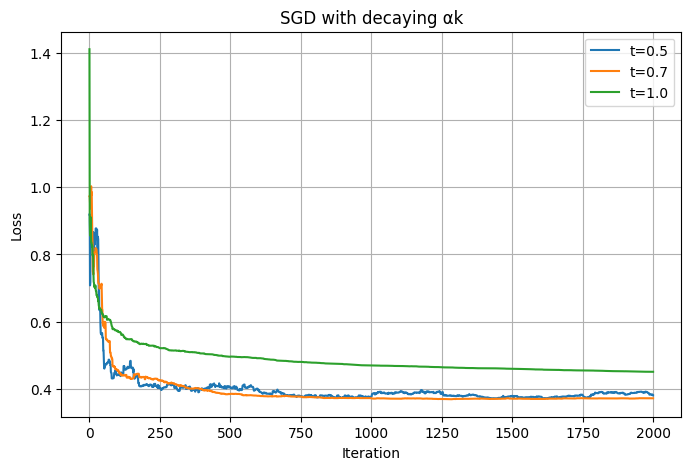

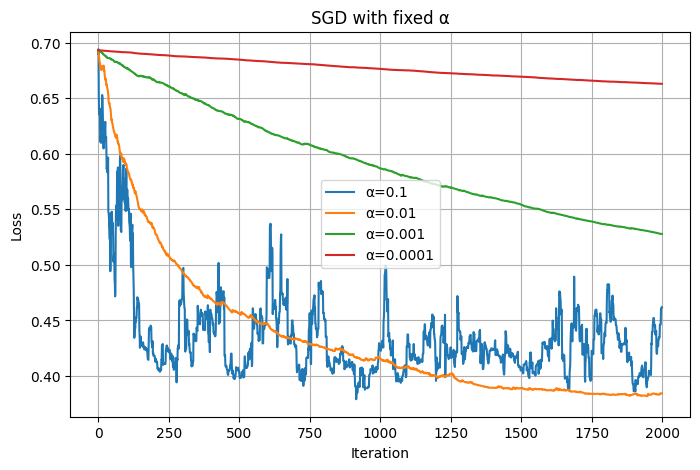

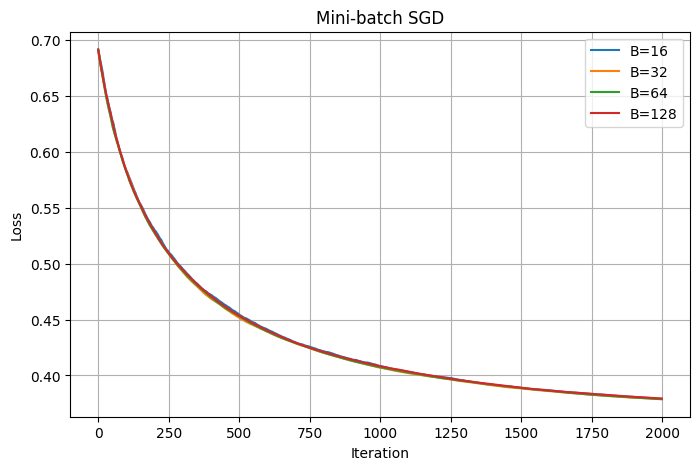

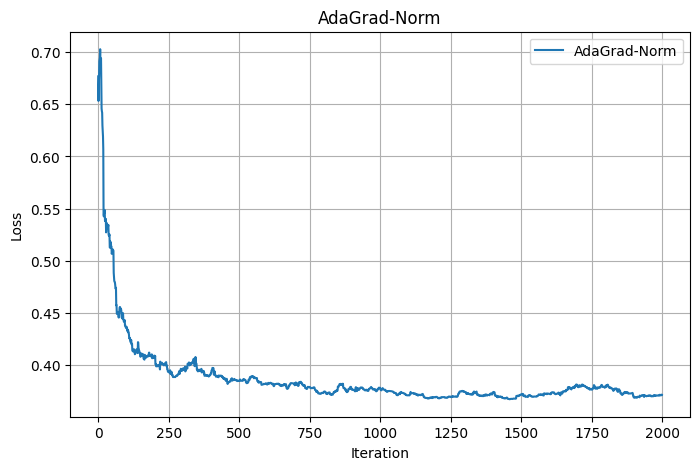

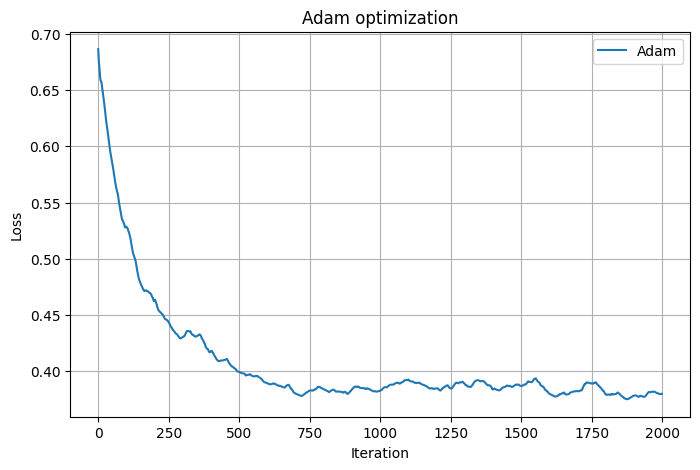

In [50]:
# SGD decaying
res_decaying = {
    "t=0.5": SGD_decaying(0.5),
    "t=0.7": SGD_decaying(0.7),
    "t=1.0": SGD_decaying(1.0)
}

plot_losses(res_decaying, "SGD with decaying αk")

# SGD fixed
res_fixed = {
    "α=0.1": SGD_fixed(0.1),
    "α=0.01": SGD_fixed(0.01),
    "α=0.001": SGD_fixed(0.001),
    "α=0.0001": SGD_fixed(0.0001),
}

plot_losses(res_fixed, "SGD with fixed α")

# minibatch
res_minibatch = {
    "B=16": minibatch_SGD(16, 0.01),
    "B=32": minibatch_SGD(32, 0.01),
    "B=64": minibatch_SGD(64, 0.01),
    "B=128": minibatch_SGD(128, 0.01),
}
plot_losses(res_minibatch, "Mini-batch SGD")

# AdaGrad Norm
res_adagrad = {"AdaGrad-Norm": AdaGrad_Norm()}
plot_losses(res_adagrad, "AdaGrad-Norm")

# Adam
res_adam = {"Adam": Adam(0.01)}
plot_losses(res_adam, "Adam optimization")


In [51]:
# PART 5
import torch
import torch.nn as nn
import torch.optim as optim


X, y = make_classification(n_samples=2000, n_features=20, n_informative=10,
                           n_redundant=3, random_state=42)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
y = 2*y - 1  #convert {0,1} -> {-1,1} like previously

n, d = X.shape


class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(d, 32)
        self.out = nn.Linear(32, 1)
        self.act = nn.Tanh()
    
    def forward(self, x):
        h = self.act(self.hidden(x))
        return self.out(h)

model_sgd = MLP()
model_adagrad = MLP()
model_adam = MLP()



In [55]:
def logistic_loss(y_pred, y_true):
    return torch.mean(torch.log(1 + torch.exp(-y_true * y_pred)))

def grad_norm(model):
    total = 0
    for p in model.parameters():
        if p.grad is not None:
            total += p.grad.norm().item() ** 2
    return np.sqrt(total)

def train(model, optimizer, steps=2000):
    grad_norms = []

    for k in range(steps):
        idx = torch.randint(0, n, (1,))
        Xb = X[idx]
        yb = y[idx]

        optimizer.zero_grad()
        pred = model(Xb)
        loss = logistic_loss(pred, yb)
        loss.backward()

        grad_norms.append(grad_norm(model))

        optimizer.step()

    return grad_norms

def smooth(values, beta=0.99):
    smoothed = []
    avg = 0
    for v in values:
        avg = beta * avg + (1 - beta) * v
        smoothed.append(avg)
    return smoothed








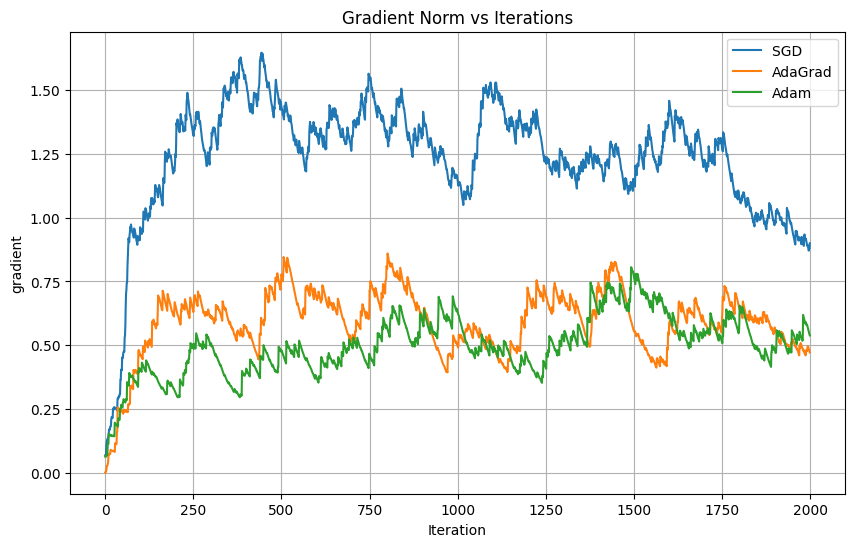

In [60]:
#experimentation
opt_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
opt_adagrad = optim.Adagrad(model_adagrad.parameters(), lr=0.1)
opt_adam = optim.Adam(model_adam.parameters(), lr=0.01)

sgd_norms = train(model_sgd, opt_sgd)
adagrad_norms = train(model_adagrad, opt_adagrad)
adam_norms = train(model_adam, opt_adam)


sgd_smooth = smooth(sgd_norms)
adagrad_smooth = smooth(adagrad_norms)
adam_smooth = smooth(adam_norms)


plt.figure(figsize=(10,6))
plt.plot(sgd_smooth, label="SGD ")
plt.plot(adagrad_smooth, label="AdaGrad")
plt.plot(adam_smooth, label="Adam")

plt.xlabel("Iteration")
plt.ylabel("gradient")
plt.title("Gradient Norm vs Iterations")
plt.legend()
plt.grid()
plt.show()
